In [1]:
import re
import numpy as np
import pandas as pd
import scipy as sc
import gensim.downloader as api
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors
from scipy.stats import norm, uniform, pearsonr
from scipy.optimize import minimize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

### 実験資材の準備

In [2]:
# YoungSoroka.2012 を前処理した BoW データをロード
df = pd.read_csv("../data/YS.2012.csv")
df

,Id,doc_id,ys_topic,ys_scale,rate,americans,bought,new,single,family,...,yiddish,peretz,ela,chaim,cunzer,uncle's,masterwork,handwritten,thesis,dissertation
0,1,text1,Economy,2.0,6.0,1.0,1.0,6.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,text2,Economy,3.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,text3,Economy,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,text4,Economy,3.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,text5,Economy,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,text896,Foreign,1.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,897,text897,Foreign,2.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,898,text898,Foreign,3.0,0.0,4.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,899,text899,Foreign,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# BoW を CountVectorizer で調整したいので BoW DataFrame から生トークン列を復元

def restore_tokens(df):
    vocab = df.columns[4:]
    bow = df.iloc[:, 4:]
    docs = []
    with tqdm(total=len(df)) as bar:
        for row in bow.iterrows():
            doc = " ".join([" ".join(int(row[1].iloc[i])*[v]) for i, v in enumerate(vocab)])
            doc = re.sub(r"\s+", " ", doc.strip())
            docs.append(doc)
            bar.update()
    return docs

# トークン列を復元
corpus = restore_tokens(df)
corpus[:3]

100%|██████████| 900/900 [00:37<00:00, 24.26it/s]


['rate rate rate rate rate rate americans bought new new new new new new single single family family homes homes dropped percent percent percent percent percent percent percent percent government today resurging mortgage mortgage mortgage rates rates rates rates rates sharp jump home home home home home home prices apparently deterred potential buyers survey survey survey departments commerce housing urban development estimated estimated estimated estimated sales sales sales sales sales sales sales sales sales sales sales sales seasonally adjusted lower lower revised annual annual annual annual level units units taking actual actual multiplying adjusting normal seasonal patterns also median median price price jumped decline decline x13 totaled totaled first months houses sold sold comparable figure plunged last response soaring interest reached bottom peaked picked came now reverse occurring drop sharpest middle middle west west south south showed xan fell copyright york times company'

In [4]:
#### コーパスから推論に必要な情報を取得

def analyze_corpus(corpus):
    """
    コーパスから推論に必要な情報を取得

    Returns:
        BoW: 文書x単語行列（出現頻度）
        word2id: 語彙ID辞書
        vocab: 語彙
        p_v: 単語の出現確率
        D: 文書数
        V: 語彙数
    """

    lowercase=True
    max_df=1.0
    min_df=3
    max_features=None

    cv = CountVectorizer(binary=False, lowercase=lowercase, max_df=max_df, min_df=min_df, max_features=max_features)
    BoW = cv.fit_transform(corpus).toarray()

    word2id = cv.vocabulary_
    vocab = cv.get_feature_names_out()

    D: int = len(corpus)
    V: int = len(vocab)
    N: int = BoW.sum()
    p_v = np.sum(BoW, axis=0)/np.sum(BoW)

    return BoW, word2id, vocab, p_v, D, V

BoW, word2id, vocab, p_v, D, V = analyze_corpus(corpus)
print(f"D={D}, V={V}")

D=900, V=7874


### 単語極性φの計算

In [5]:
# 意味方向ベクトルを計算するための単語埋め込みモデル
wv_model = KeyedVectors.load("../data/glove-wiki-gigaword-300.model")

In [6]:
# 意味方向ベクトルを計算するためのシード単語 (S_+, S_-)
pos_words = ['good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior']
neg_words = ['bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior']

#### PLSS 意味方向ベクトル

In [7]:
def get_plss_phi(pos_words, neg_words, wv, vocab):
    """ 両極のシード単語群から得られる２つの平均ベクトルから意味方向ベクトルを計算
    """

    normed_vec = wv.get_normed_vectors()
    key2index = wv.key_to_index

    def calc_beta(pos_words, neg_words):
        def mean_vec(words):
            return np.array([normed_vec[key2index[v]] for v in words if v in key2index]).mean(axis=0)

        beta = mean_vec(pos_words) - mean_vec(neg_words)
        beta = beta/np.linalg.norm(beta)
        return beta

    beta = calc_beta(pos_words, neg_words)
    phi = [(v, beta @ normed_vec[key2index[v]] if v in key2index else 0) for v in vocab]
    return phi

# 単語極性の計算
plss_phi = get_plss_phi(pos_words, neg_words, wv_model, vocab)

極性 $\phi_v > 0$ の上位単語

In [8]:
for word, polarity in sorted(plss_phi, key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word.ljust(20)}\t{polarity:>5,.4f}")

excellent           	0.4895
superb              	0.3367
impressive          	0.3362
solid               	0.3260
terrific            	0.3059
nice                	0.3041
enjoyed             	0.2998
enjoy               	0.2943
enjoying            	0.2931
restored            	0.2898
provides            	0.2849
good                	0.2833
confident           	0.2829
offers              	0.2809
reasonably          	0.2753
perfect             	0.2741
achieved            	0.2726
guide               	0.2695
impressed           	0.2649
robust              	0.2631


極性 $\phi_v < 0$ の下位単語

In [9]:
for word, polarity in sorted(plss_phi, key=lambda x: x[1])[:20]:
    print(f"{word.ljust(20)}\t{polarity:>5,.4f}")

blamed              	-0.3683
mired               	-0.3641
unnecessarily       	-0.3600
abusive             	-0.3547
caused              	-0.3482
bad                 	-0.3440
needlessly          	-0.3399
unfortunate         	-0.3375
worse               	-0.3356
horrible            	-0.3353
worsening           	-0.3330
irresponsible       	-0.3327
blame               	-0.3317
consequences        	-0.3278
beset               	-0.3238
mismanagement       	-0.3237
messy               	-0.3234
appalling           	-0.3203
plagued             	-0.3202
worsen              	-0.3200


### NumPyro による文書極性 θ の推論

In [10]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from jax import random
from numpyro.infer import MCMC, NUTS

# 複数チェーンを並列実行する場合
numpyro.set_host_device_count(3)

In [11]:
# 文書単位のPLSSモデル
def plss_model(BoW, log_p_v, phi):
    """
    PLSS モデル（文書単位）
    
    Parameters:
        BoW: 文書x単語行列 (D, V)
        log_p_v: 単語の対数出現確率 (V,)
        phi: 単語極性 (V,)
    """
    D, V = BoW.shape
    
    # prior: theta ~ N(0, 1)
    with numpyro.plate('docs', D):
        theta = numpyro.sample('theta', dist.Normal(0, 1))
    
    # likelihood: log p(d|theta, phi) = sum_v n_dv * log p(v|theta_d, phi)
    # log p(v|theta, phi) = log_softmax(log(p_v) + theta * phi)
    
    # 各文書のlogitsを計算: shape (D, V)
    # theta: (D,), phi: (V,) -> logits: (D, V)
    logits = log_p_v + theta[:, None] * phi  # broadcasting
    
    # log_softmax で正規化
    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    # 対数尤度: sum_v n_dv * log p(v|theta_d, phi)
    log_likelihood = jnp.sum(BoW * log_probs, axis=1)
    
    # target += sum(log_likelihood)
    numpyro.factor('obs', jnp.sum(log_likelihood))

In [12]:
# データの準備
phi = jnp.array([p for _, p in plss_phi])  # 単語極性
log_p_v = jnp.log(jnp.array(p_v))          # 対数単語確率
BoW_jnp = jnp.array(BoW)                    # BoW行列

# MCMC 実行
nuts_kernel = NUTS(plss_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=3)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, BoW_jnp, log_p_v, phi, extra_fields=('potential_energy',))

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2025-12-16 00:24:07.008633: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce-window.4 = f32[900,247]{1,0} reduce-window(%constant.1352, %constant.248), window={size=1x32 stride=1x32 pad=0_0x15_15}, to_apply=%region_12.487

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-12-16 00:24:07.172789: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.165216751s
Constant folding an instruction is taking > 1s:

  %reduce-window.4 = f32[900,247]{1,0} reduce-window(%constant.1352, %constant.248), window={size=1x32 stride=1x32 pad=0_0x15_15}, to_apply=%region

In [13]:
# 結果の要約
mcmc.print_summary()

pe = mcmc.get_extra_fields()['potential_energy']
print(f'Expected log joint density: {np.mean(-pe):.2f}')


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]     -0.75      0.72     -0.75     -1.93      0.42   4622.54      1.00
  theta[1]      0.95      0.59      0.95     -0.00      1.92   4483.47      1.00
  theta[2]      0.38      0.86      0.39     -0.98      1.82   4858.64      1.00
  theta[3]      3.61      0.60      3.61      2.53      4.53   4010.80      1.00
  theta[4]     -0.72      0.58     -0.71     -1.63      0.24   3691.58      1.00
  theta[5]      1.06      0.68      1.06     -0.02      2.19   3693.01      1.00
  theta[6]      2.87      0.63      2.88      1.88      3.99   4862.14      1.00
  theta[7]      0.59      0.62      0.58     -0.38      1.66   4826.14      1.00
  theta[8]      0.11      0.52      0.12     -0.70      1.00   4996.10      1.00
  theta[9]      2.06      0.75      2.06      0.90      3.35   3356.03      1.00
 theta[10]      0.29      0.66      0.31     -0.80      1.33   4361.19      1.00
 theta[11]     -1.91      0

In [14]:
# サンプルの取得
samples = mcmc.get_samples()
theta_samples = np.array(samples['theta'])
theta_mean = theta_samples.mean(axis=0)
theta_std = theta_samples.std(axis=0)

print(f"theta shape: {theta_samples.shape}")
print(f"theta mean range: {theta_mean.min():.3f} ~ {theta_mean.max():.3f}")

theta shape: (3000, 900)
theta mean range: -3.764 ~ 5.591


In [15]:
# 人手評価との相関
human_scale = df['ys_scale'].values
correlation, p_value = pearsonr(theta_mean, human_scale)
print(f"Pearson correlation: {correlation:.4f} (p={p_value:.2e})")

Pearson correlation: 0.3686 (p=2.41e-30)


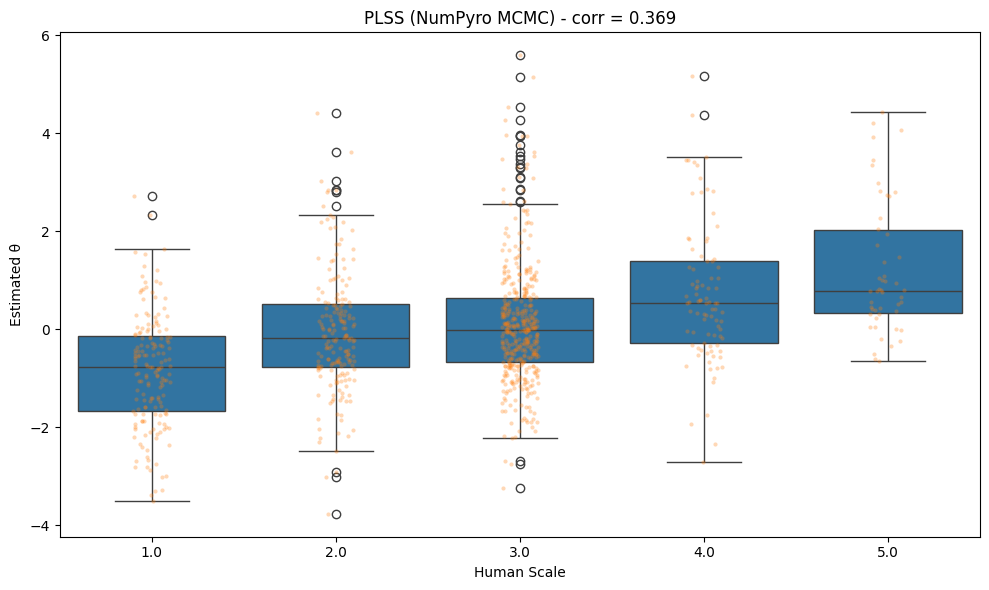

In [16]:
# 可視化
fig, ax = plt.subplots(figsize=(10, 6))

result_df = pd.DataFrame({
    'scale': human_scale,
    'theta': theta_mean
})

sns.boxplot(data=result_df, x='scale', y='theta', ax=ax)
sns.stripplot(data=result_df, x='scale', y='theta', ax=ax, alpha=0.3, size=3)

ax.set_title(f'PLSS (NumPyro MCMC) - corr = {correlation:.3f}')
ax.set_xlabel('Human Scale')
ax.set_ylabel('Estimated θ')

plt.tight_layout()
plt.show()